# Masking out ocean basins
[cmip6_preprocessing](https://github.com/jbusecke/cmip6_preprocessing) is able to use and aggregate regionmask provided by [Natural Earth](http://www.naturalearthdata.com/) via the [regionmask package](https://github.com/mathause/regionmask).

This functionality needs the upstream master of regionmask:
> In a cell do `!pip install git+https://github.com/mathause/regionmask.git` and restart the notebook

Also, [cmip6_preprocessing](https://github.com/jbusecke/cmip6_preprocessing) is currently not installed by default: 
> In a cell do `!pip install git+https://github.com/jbusecke/cmip6_preprocessing.git` and restart the notebook

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.0.154:42411")
client

Client Scheduler: tcp://10.32.0.154:42411 Dashboard: /user/0000-0001-8571-865x/proxy/38459/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [1]:
# !pip install git+https://github.com/mathause/regionmask.git
# !pip install -e ../

In [2]:
import regionmask
import intake
import matplotlib.pyplot as plt
from cmip6_preprocessing.preprocessing import combined_preprocessing
import xarray as xr
import numpy as np

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


Lets import ocean temperature data from a variety of models to see if the masking works well.

In [3]:
# import example cloud datasets
col_url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)
cat = col.search(source_id=['CAMS-CSM1-0', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'EC-Earth3-Veg',
                            'MIROC-ES2L', 'MIROC6', 'HadGEM3-GC31-LL', 'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'MRI-ESM2-0',
                            'NorCPM1', 'GFDL-CM4', 'GFDL-ESM4', 'NESM3'],
                 experiment_id='historical', variable_id='thetao')
data_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False},
                                preprocess=combined_preprocessing)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 20 group(s)
[########                                ] | 20% Completed |  2.7sMIROC6: No units found
MIROC-ES2L: No units found
[####################                    ] | 50% Completed |  3.8sMIROC-ES2L: No units found
MIROC6: No units found
[####################                    ] | 50% Completed |  4.5sMIROC6: No units found
[####################                    ] | 50% Completed |  4.7sMIROC-ES2L: No units found
[########################                ] | 60% Completed |  5.3sMIROC6: No units found
[########################                ] | 60% Completed |  5.6sMIROC6: No units found
[##########################              ] | 65% Completed |  6.6sMIROC6: No units found
[############################            ] | 70% Completed |  7.4sMIROC6: No units found
[############################

First we need to load the natural earth ocean basins.

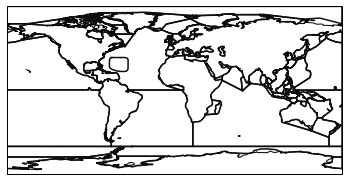

In [4]:
# load ocean basin data
basins = regionmask.defined_regions.natural_earth.ocean_basins_50
basins.plot(add_ocean=False, add_label=False)

This is a neat dataset, but for large scale climate analysis it is often useful to separate the large scale ocean basins (e.g. the full Pacific, with all marginal seas included). For this we can use `merge_mask`.

In [5]:
from cmip6_preprocessing.regionmask import merged_mask

When using the defaults this will index the North and South Pacific with numeric values of 2 and 3 respectively.
The Maritime Continent gets a separate index (4). We will now load example data from many CMIP6 models, create the mask, and select only the points with values 2,3, and 4.

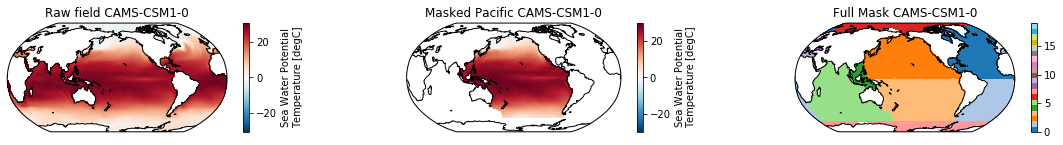

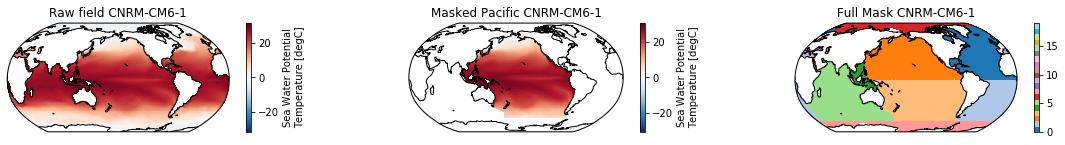

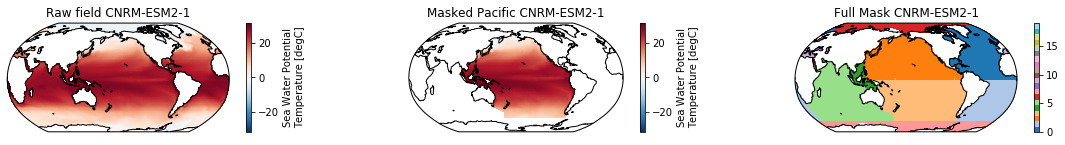

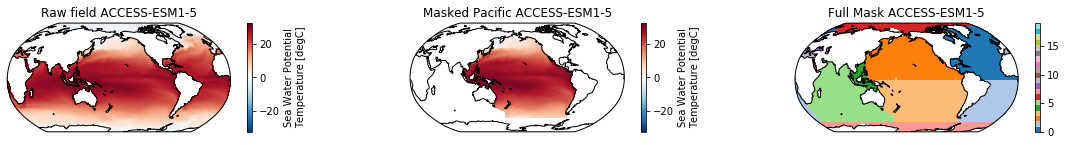

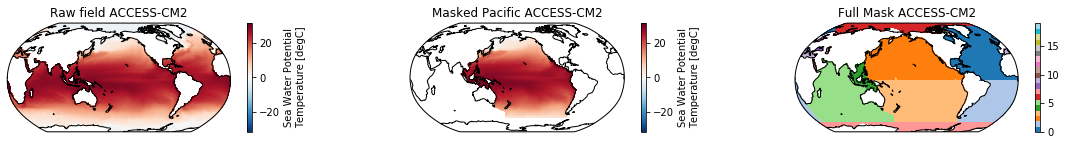

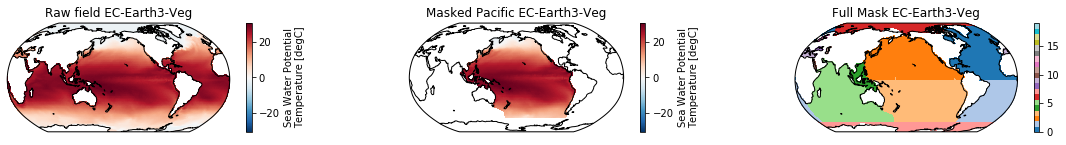

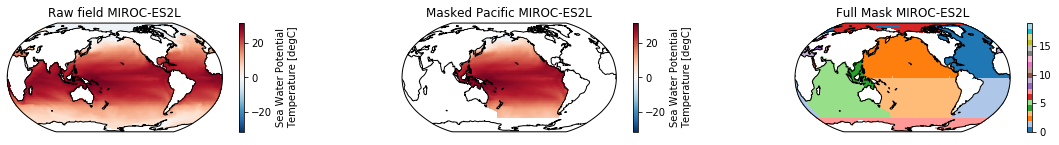

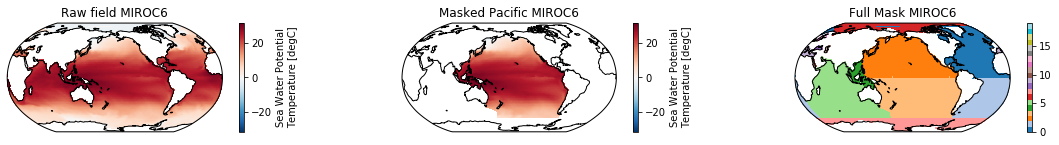

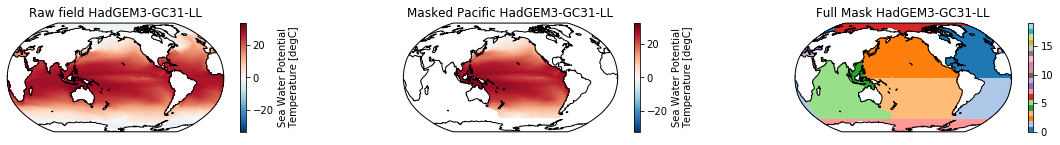

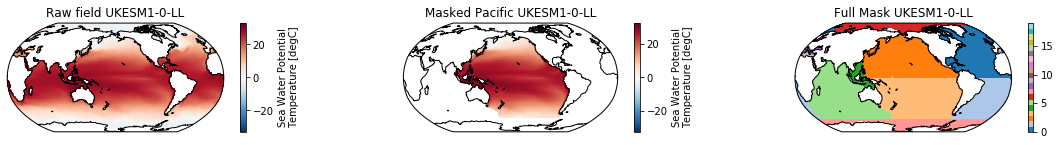

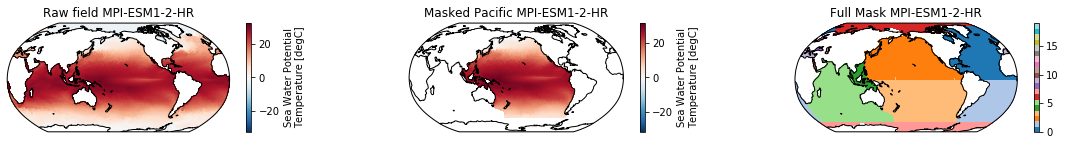

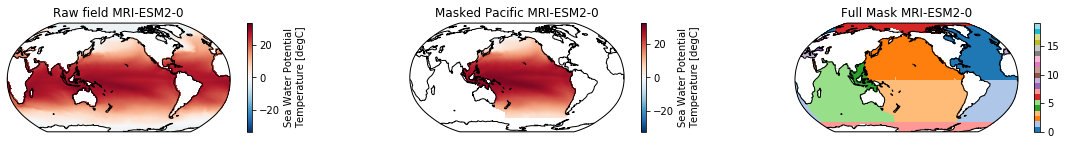

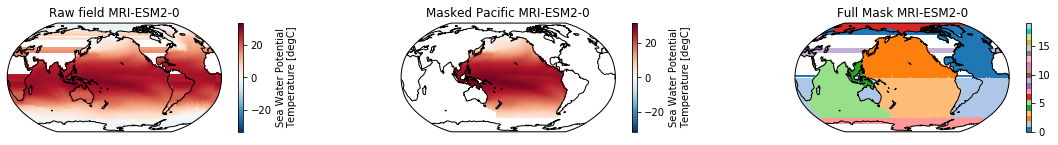

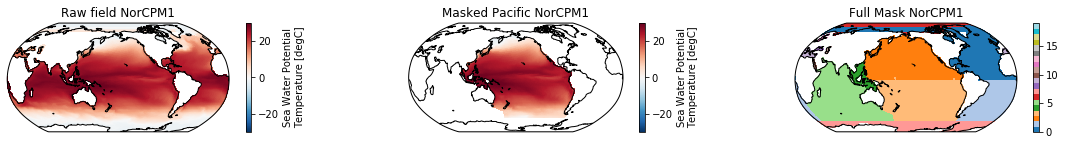

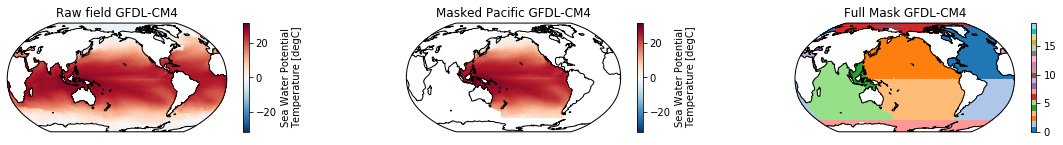

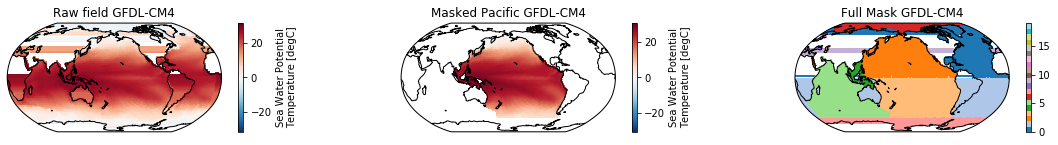

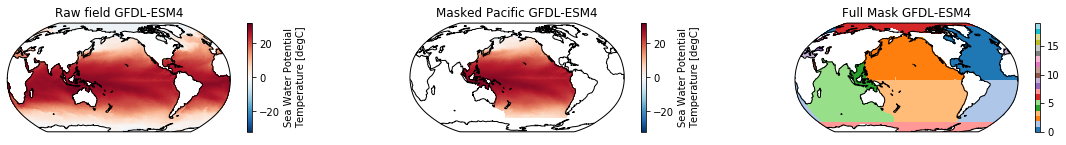

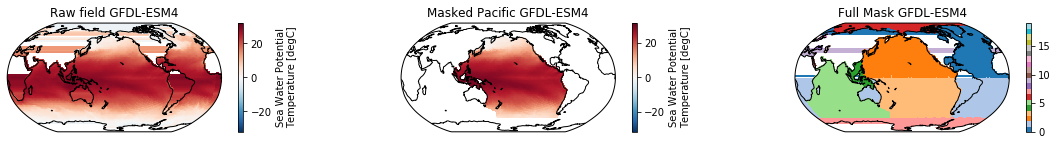

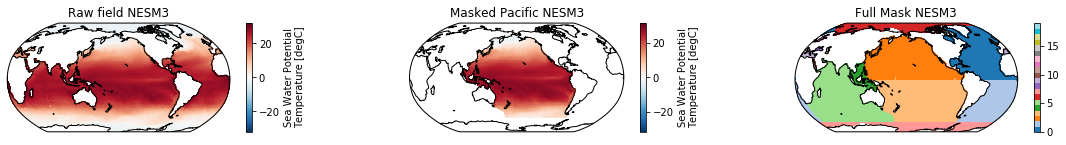

In [6]:
# loop over models and mask out the pacific
import cartopy.crs as ccrs

for k, ds in data_dict.items():
    if 'lev' in ds.dims:
        model = ds.attrs['source_id']
        if 'member_id' in ds.dims:
            ds = ds.isel(member_id=0)
        ds = ds.thetao.isel(time=0, lev=0).squeeze()

        mask = merged_mask(basins,ds)

        kwargs = dict(x='lon', y='lat',transform = ccrs.PlateCarree(), infer_intervals=False)
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[20,2], subplot_kw={'projection':ccrs.Robinson(190)})
        ds.plot(ax=ax1, **kwargs)
        ax1.set_title(f"Raw field {model}")
        
        ds_masked = ds.where(np.logical_or(np.logical_or(mask == 2, mask==3),mask==4)) # Pacific + Maritime Continent
        ds_masked.plot(ax=ax2, **kwargs)
        ax2.set_title(f"Masked Pacific {model}")
        mask.plot(ax=ax3, cmap='tab20', vmin=0, vmax=19, **kwargs)
        ax3.set_title(f"Full Mask {model}")
        for ax in [ax1, ax2, ax3]:
            ax.coastlines()

The masked dataset now only contains values in the Pacific and can be further manipulated.